# **Covid-19 Prediction Using CNN And Tensorflow+Flask **

In [1]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from imutils import paths
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import cv2
import os

In [2]:
dataset_path = './dataset'

In [3]:
normal_images = list(paths.list_images(f"{dataset_path}/normal"))
covid_images = list(paths.list_images(f"{dataset_path}/covid"))

## Data preprocessing

In [4]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-3 
EPOCHS = 7
BS = 8 

In [5]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
imagePaths = list(paths.list_images(dataset_path))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

In [6]:
data_shuffled, labels_shuffled = shuffle(data, labels)

In [7]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels_shuffled)
labels = to_categorical(labels)
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data_shuffled, labels, test_size=0.20, stratify=labels, random_state=42)
# initialize the training data augmentation object
trainAug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

## Model

In [8]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel) 
headModel = Dropout(0.25)(headModel) 
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

### Training

In [9]:
# compile our model
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the head of the network
H = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/7
32/32 [==============================] - 58s 2s/step - loss: 0.7166 - accuracy: 0.5904 - val_loss: 0.6338 - val_accuracy: 0.7077
Epoch 2/7
32/32 [==============================] - 60s 2s/step - loss: 0.6273 - accuracy: 0.6586 - val_loss: 0.6136 - val_accuracy: 0.6923
Epoch 3/7
32/32 [==============================] - 58s 2s/step - loss: 0.6231 - accuracy: 0.6265 - val_loss: 0.5927 - val_accuracy: 0.6769
Epoch 4/7
32/32 [==============================] - 58s 2s/step - loss: 0.6041 - accuracy: 0.6667 - val_loss: 0.6091 - val_accuracy: 0.6308
Epoch 5/7
32/32 [==============================] - 58s 2s/step - loss: 0.5873 - accuracy: 0.7028 - val_loss: 0.5779 - val_accuracy: 0.7077
Epoch 6/7
32/32 [==============================] - 59s 2s/step - loss: 0.5621 - accuracy: 0.7309 - val_loss: 0.5777 - val_accuracy: 0.7077
Epoch 7/7
32/32 [==============================] - 59s 2s/step - loss: 0.5597 - accuracy: 

### Plot trining metrics

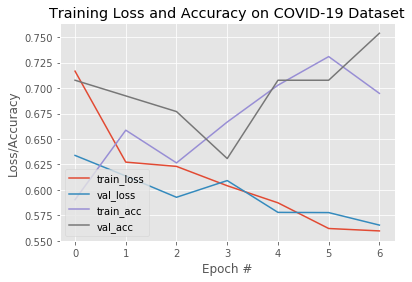

In [10]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

### Evaluation

In [11]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

       covid       0.75      0.90      0.82        40
      normal       0.76      0.52      0.62        25

    accuracy                           0.75        65
   macro avg       0.76      0.71      0.72        65
weighted avg       0.76      0.75      0.74        65



#### Confusion matrix

In [12]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[36  4]
 [12 13]]
acc: 0.7538
sensitivity: 0.9000
specificity: 0.5200


Now save the model

In [13]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('covid_model.h5') 

Test loaded model

In [14]:
from tensorflow.keras.models import load_model
# Recreate the exact same model, including its weights and the optimizer
new_model = load_model('covid_model.h5')

# Show the model architecture
new_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

Test on covid image:

In [16]:
img_width, img_height = 224, 224
img = image.load_img('test2.jpeg', target_size = (img_width, img_height))
x = image.img_to_array(img)
img = np.expand_dims(x, axis = 0)

pred = new_model.predict(img)
print(pred)

#one = new_model.predict('../input/covid-chest-xray/images/1-s2.0-S1684118220300608-main.pdf-002.jpg', batch_size = BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
print(np.argmax(pred, axis=1)[0])
if np.argmax(pred, axis=1)[0] == 1:
    plt.title('Prediction: Non_Covid-19')
else:
    plt.title('Prediction: Covid-19')
plt.imshow(x/255.)

AttributeError: 'numpy.ndarray' object has no attribute 'load_img'

## Credits
This notebook is based on this tutorial - [link]

In [29]:
import numpy as np
#from tensorflow.keras.preprocessing import image
#img_width, img_height = 224, 224
#img = image.load_img('test2.jpeg', target_size = (img_width, img_height))
#x = image.img_to_array(img)
#img = np.expand_dims(x, axis = 0)
#feature_maps = new_model.predict(img)
#square = 8
#for fmap in feature_maps:
    # plot all 64 maps in an 8x8 squares
#    ix = 1
#    for _ in range(square):
#        for _ in range(square):
#            # specify subplot and turn of axis
#            ax = plt.subplot(square, square, ix)
#            ax.set_xticks([])
#            ax.set_yticks([])
            # plot filter channel in grayscale
#            plt.imshow(fmap[0, :, :, ix-1], cmap='gray')
#            ix += 1
    # show the figure
#    plt.show()

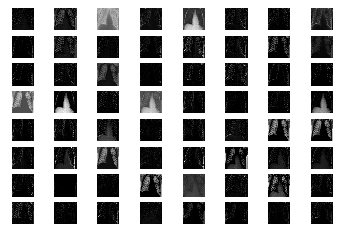

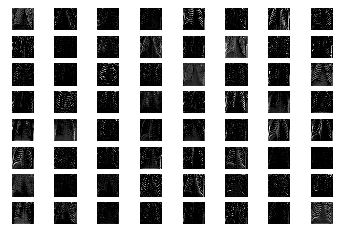

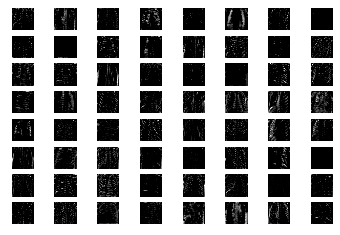

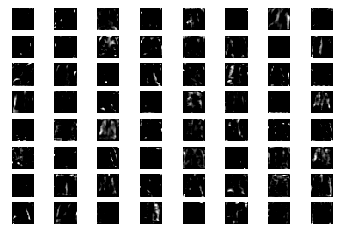

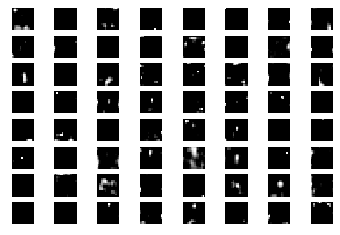

In [45]:
# visualize feature maps output from each block in the vgg model
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
# load the model
model = load_model('covid_model.h5')
# redefine model to output right after the first hidden layer
ixs = [2, 5, 9, 13, 17]
outputs = [model.layers[i].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)
# load the image with the required shape
img = load_img('test2.jpeg', target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot the output from each block
square = 8
for fmap in feature_maps:
	# plot all 64 maps in an 8x8 squares
	ix = 1
	for _ in range(square):
		for _ in range(square):
			# specify subplot and turn of axis
			ax = plt.subplot(square, square, ix)
			ax.set_xticks([])
			ax.set_yticks([])
			# plot filter channel in grayscale
			plt.imshow(fmap[0, :, :, ix-1], cmap='gray')
			ix += 1
	# show the figure
	plt.show()

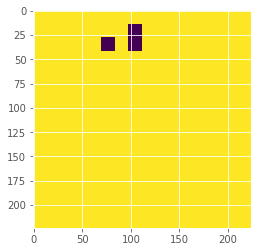

In [30]:
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
# convert the image pixels to a numpy array
# reshape data for the model
image = x.reshape((1, x.shape[0], x.shape[1], x.shape[2]))
# prepare the image for the VGG model
image = preprocess_input(image)
yhat = feature_maps
temp = image[0]
#print(temp.shape)
heatmap = np.zeros((224,224))
correct_class = np.argmax(yhat)
for n,(x,y,image) in enumerate(iter_occlusion(temp,14)):
    heatmap[x:x+14,y:y+14] = model.predict(image.reshape((1, image.shape[0], image.shape[1], image.shape[2])))[0][correct_class]
    #print(x,y,n,' - ',image.shape)
heatmap1 = heatmap/heatmap.max()
plt.imshow(heatmap)

In [26]:
import numpy as np

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.activations import relu

%matplotlib inline
import matplotlib.pyplot as plt
def iter_occlusion(image, size=8):

    occlusion = np.full((size * 5, size * 5, 1), [0.5], np.float32)
    occlusion_center = np.full((size, size, 1), [0.5], np.float32)
    occlusion_padding = size * 2

    # print('padding...')
    image_padded = np.pad(image, ( \
                        (occlusion_padding, occlusion_padding), (occlusion_padding, occlusion_padding), (0, 0) \
                        ), 'constant', constant_values = 0.0)

    for y in range(occlusion_padding, image.shape[0] + occlusion_padding, size):

        for x in range(occlusion_padding, image.shape[1] + occlusion_padding, size):
            tmp = image_padded.copy()

            tmp[y - occlusion_padding:y + occlusion_center.shape[0] + occlusion_padding, \
                x - occlusion_padding:x + occlusion_center.shape[1] + occlusion_padding] \
                = occlusion

            tmp[y:y + occlusion_center.shape[0], x:x + occlusion_center.shape[1]] = occlusion_center

            yield x - occlusion_padding, y - occlusion_padding, \
                  tmp[occlusion_padding:tmp.shape[0] - occlusion_padding, occlusion_padding:tmp.shape[1] - occlusion_padding]

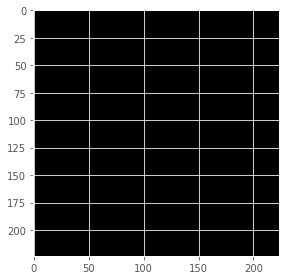

In [31]:
import skimage.io as io
#creating mask from the standardised heatmap probabilities
mask = heatmap1 < 0.85
mask1 = mask *256
mask = mask.astype(int)
io.imshow(mask,cmap='gray')